In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import collections

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy.stats as stats

In [2]:
d = pd.read_csv('./rethinking/data/reedfrogs.csv', sep=';')
d.sort_values('density', inplace=True)
d= d.reset_index().drop('index', axis=1)

In [3]:
d.describe()

,density,surv,propsurv
count,48.000000,48.000000,48.000000
mean,23.333333,16.312500,0.721607
std,10.382746,9.884775,0.266416
min,10.000000,4.000000,0.114286
25%,10.000000,9.000000,0.496429
50%,25.000000,12.500000,0.885714
75%,35.000000,23.000000,0.920000
max,35.000000,35.000000,1.000000


In [4]:
with pm.Model() as m121:
    
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=len(d))
    p = np.exp(alpha) / ( 1 + np.exp(alpha) )
    
    s = pm.Binomial('s', n=d['density'].values, p=p, observed=d['surv'])
    
    m121_map = pm.find_MAP()
    m121_trace = pm.sample(1000, start=m121_map)

100%|██████████| 1000/1000 [00:01<00:00, 930.18it/s]


In [5]:
with pm.Model() as m122:
    
    alpha_0 = pm.Normal('alpha_0', 0, 1)
    sigma_0 = pm.HalfCauchy('sigma_0', 1)
    
    alpha_tank = pm.Normal('alpha_tank', mu=alpha_0, sd=sigma_0, shape=len(d))
    p = np.exp(alpha_tank) / ( 1 + np.exp(alpha_tank) )
    
    s = pm.Binomial('s', n=d['density'].values, p=p, observed=d['surv'])
    
    m122_map = pm.find_MAP()
    m122_trace = pm.sample(1000, start=m121_map)

100%|██████████| 1000/1000 [00:08<00:00, 113.00it/s]


In [6]:
m122_trace_df = pm.trace_to_dataframe(m122_trace)

In [7]:
post_props = (np.exp(m122_trace_df.iloc[:, :-2].mean()) / (1 + np.exp(m122_trace_df.iloc[:, :-2].mean()))).values

In [8]:
d.propsurv.mean()

0.7216071428571428

In [9]:
mean_prop = np.exp(m122_trace_df.alpha_0.mean()) / (1 + np.exp(m122_trace_df.alpha_0.mean()))

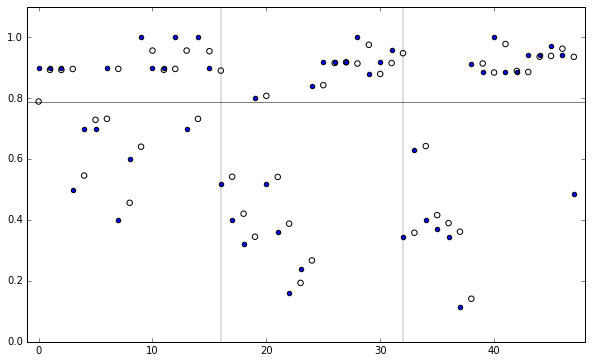

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

ax.set_xlim([-1, 48])
ax.set_ylim([0, 1.1])

ax.vlines(16, 0, 1.1, lw=0.25)
ax.vlines(32, 0, 1.1, lw=0.25)

ax.scatter(d.index, d.propsurv)
ax.scatter(d.index, post_props, facecolors='none', edgecolors='k', s=30)

ax.hlines(mean_prop, -1, 48, lw=0.5)

In [11]:
m122_trace_df[['alpha_0', 'sigma_0']].head()

,alpha_0,sigma_0
0,0.099122,0.786656
1,0.099122,0.786656
2,0.068688,0.159109
3,0.430961,0.852117
4,1.116137,1.615438


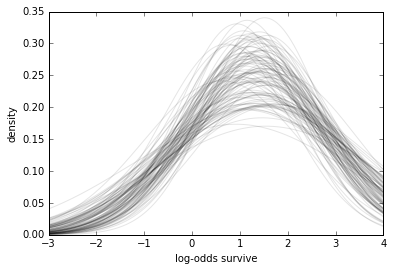

In [12]:
rvs = []

for index, row in m122_trace_df[['alpha_0', 'sigma_0']].tail(100).iterrows():
    alpha = row['alpha_0']
    sigma = row['sigma_0']
    
    sample_log_odds = stats.norm.rvs(loc=alpha, scale=sigma, size=80)
    sample_probs = np.exp(sample_log_odds) / (1 + np.exp(sample_log_odds))
    rvs.extend(list(sample_probs))
    
    linspace = np.linspace(-3, 4, 1000)
    pdf = stats.norm.pdf(linspace, loc=alpha, scale=sigma)

    plt.plot(linspace, pdf, alpha=0.1, c='k')
    
plt.xlim([-3, 4])
plt.ylim([0, 0.35])
plt.xlabel('log-odds survive')
plt.ylabel('density');

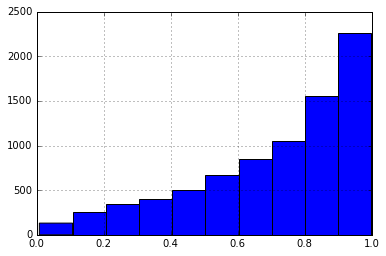

In [13]:
pd.Series(rvs).hist()

In [14]:
0.6 / 0.4

1.4999999999999998

In [15]:
# Gaussian distribution of individual pond log-odds of survival
a = 1.4
sigma = 1.5

nponds = 60
ni = [5]  * 15 + [10] * 15 + [25] * 15 + [35] * 15

# simulate 60 intercepts for each pond
a_pond = stats.norm.rvs(loc=a, scale=sigma, size=nponds)

# data frame
dsim = pd.DataFrame({'ni': ni, 'true_a': a_pond})
dsim['true_p'] = dsim['true_a'].apply(lambda x: np.exp(x) / (1 + np.exp(x)))
dsim['si'] = stats.binom.rvs(n=dsim['ni'], p=dsim['true_p'])

dsim['p_nopool'] = dsim['si'] / dsim['ni']

In [16]:
dsim.head()

,ni,true_a,true_p,si,p_nopool
0,5,3.883408,0.979834,5,1.0
1,5,2.197984,0.900068,4,0.8
2,5,3.747989,0.976977,5,1.0
3,5,-2.274963,0.093218,2,0.4
4,5,1.898817,0.869758,4,0.8


In [17]:
with pm.Model() as m123:
    
    alpha_0 = pm.Normal('alpha_0', 0, 1)
    sigma_0 = pm.HalfCauchy('sigma_0', 1)
    
    alpha_tank = pm.Normal('alpha_tank', mu=alpha_0, sd=sigma_0, shape=len(dsim))
    p = np.exp(alpha_tank) / ( 1 + np.exp(alpha_tank) )
    
    s = pm.Binomial('s', n=dsim['ni'].values, p=p, observed=dsim['si'])
    
    m123_trace = pm.sample(1000)

100%|██████████| 1000/1000 [00:10<00:00, 99.37it/s]


In [18]:
m123_trace_df = pm.trace_to_dataframe(m123_trace)
dsim['p_partpool'] = m123_trace_df.mean().apply(lambda x: np.exp(x) / (1 + np.exp(x))).iloc[:-2].values

In [19]:
nopool_error = np.abs(dsim['p_nopool'] - dsim['true_p'])
partpool_error = np.abs(dsim['p_partpool'] - dsim['true_p'])

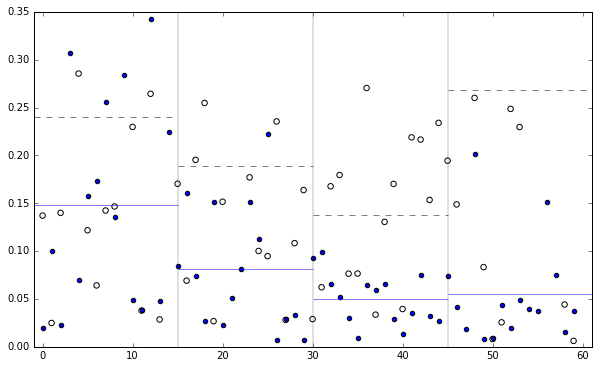

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

ax.set_xlim([-1, 61])
ax.set_ylim([0, 0.35])

ax.vlines(15, 0, 1.1, lw=0.25)
ax.vlines(30, 0, 1.1, lw=0.25)
ax.vlines(45, 0, 1.1, lw=0.25)

ax.scatter(dsim.index, nopool_error)
ax.scatter(dsim.index, partpool_error, facecolors='none', edgecolors='k', s=30)

ax.hlines(nopool_error[:15].mean(), -1, 15, lw=0.5, color='b')
ax.hlines(partpool_error[:15].mean(), -1, 15, lw=0.5, color='k', linestyle='dashed')

ax.hlines(nopool_error[15:30].mean(), 15, 30, lw=0.5, color='b')
ax.hlines(partpool_error[15:30].mean(), 15, 30, lw=0.5, color='k', linestyle='dashed')

ax.hlines(nopool_error[30:45].mean(), 30, 45, lw=0.5, color='b')
ax.hlines(partpool_error[30:45].mean(), 30, 45, lw=0.5, color='k', linestyle='dashed')

ax.hlines(nopool_error[45:].mean(), 45, 61, lw=0.5, color='b')
ax.hlines(partpool_error[45:].mean(), 45, 61, lw=0.5, color='k', linestyle='dashed')

### 12.3 More than one type of cluster

In [21]:
d = pd.read_csv('./rethinking/data/chimpanzees.csv', sep=';')

In [22]:
d.describe()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
count,504.000000,252.00000,504.000000,504.000000,504.000000,504.000000,504.00000,504.000000
mean,4.000000,5.00000,0.500000,3.500000,36.375000,0.500000,0.56746,0.579365
std,2.001987,2.00398,0.500497,1.709522,20.790832,0.500497,0.49592,0.494151
min,1.000000,2.00000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000
25%,2.000000,3.00000,0.000000,2.000000,18.000000,0.000000,0.00000,0.000000
50%,4.000000,5.00000,0.500000,3.500000,36.000000,0.500000,1.00000,1.000000
75%,6.000000,7.00000,1.000000,5.000000,54.000000,1.000000,1.00000,1.000000
max,7.000000,8.00000,1.000000,6.000000,72.000000,1.000000,1.00000,1.000000


In [23]:
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [24]:
d.drop('recipient', axis=1, inplace=True)

$$ L_i \sim Binomial(1, p_i)$$
$$ logit(p_i) = \alpha + \alpha_{actor_i} + (\beta_P + \beta_{PC}C_i)P_i$$
$$ \alpha_{actor} \sim Normal(0, sigma_{actor}) $$
$$ \alpha \sim Normal(0, 10) $$
$$ \beta_{P} \sim Normal(0, 10) $$
$$ \beta_{PC} \sim Normal(0, 10) $$
$$ \sigma_{actor} \sim HalfCauchy(0, 1)$$

In [25]:
d.actor.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [26]:
with pm.Model() as m124:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_p = pm.Normal('beta_p', mu=0, sd=10)
    beta_pc = pm.Normal('beta_pc', mu=0, sd=10)
    
    sigma_actor = pm.HalfCauchy('sigma_actor', 1)
    alpha_actor = pm.Normal('alpha_actor', mu=0, sd=sigma_actor, shape=7)
    
    line = alpha + alpha_actor[d['actor'] - 1] + (beta_p + beta_pc * d['condition']) * d['prosoc_left']
    p = np.exp(line) / ( 1 + np.exp(line))
    
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=d['pulled_left'])
    
    m124_trace = pm.sample(1000)

100%|██████████| 1000/1000 [00:21<00:00, 47.13it/s]


In [27]:
m124_trace_df = pm.trace_to_dataframe(m124_trace)

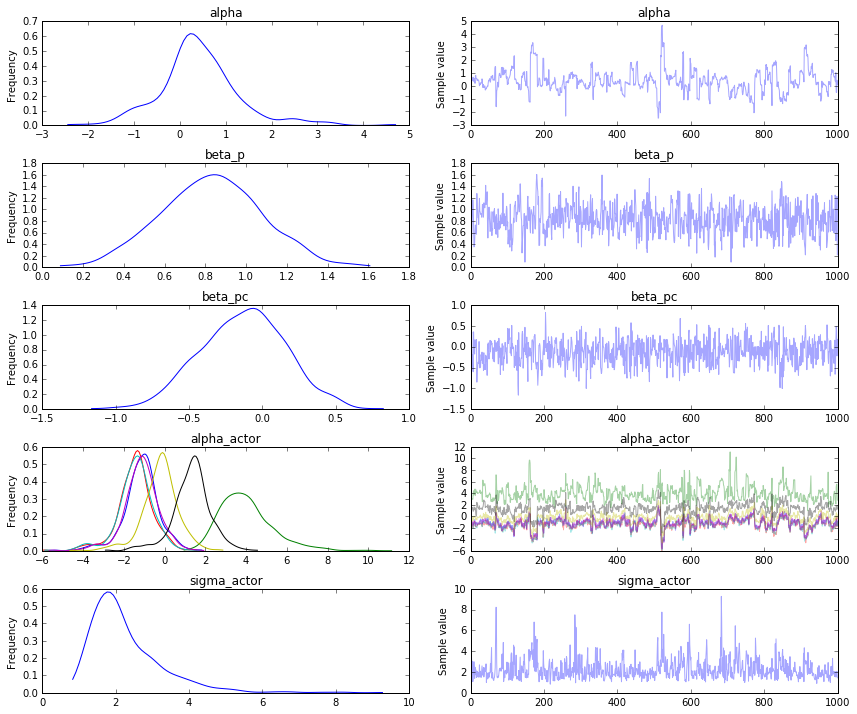

In [28]:
pm.traceplot(m124_trace);

In [29]:
m124_trace_df.mean()

beta_pc          -0.132346
sigma_actor       2.277699
beta_p            0.832192
alpha             0.423989
alpha_actor__0   -1.139343
alpha_actor__1    4.011559
alpha_actor__2   -1.449808
alpha_actor__3   -1.440084
alpha_actor__4   -1.152217
alpha_actor__5   -0.209538
alpha_actor__6    1.329698
dtype: float64

In [30]:
d.block.unique()

array([1, 2, 3, 4, 5, 6])

In [41]:
with pm.Model() as m125:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_p = pm.Normal('beta_p', mu=0, sd=10)
    beta_pc = pm.Normal('beta_pc', mu=0, sd=10)
    
    sigma_actor = pm.HalfCauchy('sigma_actor', 1)
    alpha_actor = pm.Normal('alpha_actor', mu=0, sd=sigma_actor, shape=7)
    
    sigma_block = pm.HalfCauchy('sigma_block', 1)
    alpha_block = pm.Normal('alpha_block', mu=0, sd=sigma_block, shape=6)
    
    line = (alpha 
            + alpha_actor[d['actor'] - 1] 
            + alpha_block[d['block'] - 1]
            + (beta_p + beta_pc * d['condition']) * d['prosoc_left'])
    
    p = np.exp(line) / ( 1 + np.exp(line))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=d['pulled_left'])
    
    m125_trace = pm.sample(200, tune=200, njobs=2)


100%|██████████| 200/200 [00:17<00:00, 11.13it/s]

In [42]:
m125_trace

<MultiTrace: 2 chains, 200 iterations, 9 variables>

In [43]:
m125_trace_df = pm.trace_to_dataframe(m125_trace)

In [46]:
pm.gelman_rubin(m125_trace)

{'alpha': 0.99749686716300012,
 'alpha_actor': array([ 0.99749687,  0.99749687,  0.99749687,  0.99749687,  0.99749687,
         0.99749687,  0.99749687]),
 'alpha_block': array([ 0.99749687,  0.99749687,  0.99749687,  0.99749687,  0.99749687,
         0.99749687]),
 'beta_p': 0.99749686716300023,
 'beta_pc': 0.99749686716300012,
 'sigma_actor': 0.99749686716300012,
 'sigma_actor_log_': 0.99749686716300012,
 'sigma_block': 0.99749686716300023,
 'sigma_block_log_': 0.99749686716300012}

In [52]:
m125_ppc_samples = pm.sample_ppc(samples=1000, model=m125, trace=m125_trace)